# 1.使用神经网络做气温预测

## 1. 处理数据

数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [67]:
import pandas as pd  # 数据基本处理
import warnings
warnings.filterwarnings("ignore") 


features = pd.read_csv('../data/temps.csv')
print('数据维度:', features.shape)
features.head(n=10)


数据维度: (348, 9)


,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41
5,2016,1,6,Wed,40,44,46.1,51,40
6,2016,1,7,Thurs,44,51,46.2,45,38
7,2016,1,8,Fri,51,45,46.3,48,34
8,2016,1,9,Sat,45,48,46.4,50,47
9,2016,1,10,Sun,48,50,46.5,52,49


### 1.处理时间

In [68]:
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

### 2.绘制趋势图

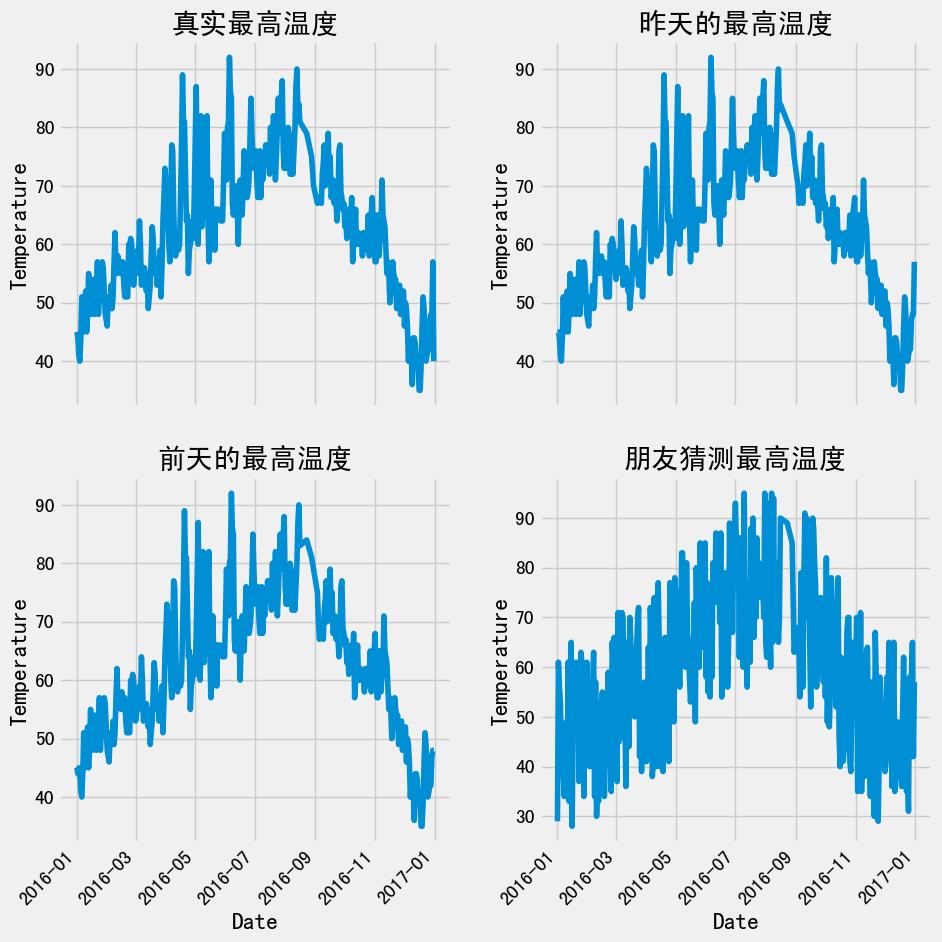

In [69]:
import matplotlib.pyplot as plt

# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('真实最高温度')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('昨天的最高温度')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('前天的最高温度')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('朋友猜测最高温度')

plt.tight_layout(pad=2)

### 3.one-hot编码
`pd.get_dummies`：是Pandas库中的一个函数，用于对某一列或多列数据进行one-hot编码。在机器学习中，我们通常需要将文本或分类变量转换为数值变量，以便在模型中使用。其中，one-hot编码是一种常用的方法，它将每个分类变量映射到一个唯一的整数值，并将该整数值转换为一个二进制向量，向量的长度等于分类变量的取值个数，其中只有对应的整数值位置为1，其余位置均为0。这样，每个分类变量就可以表示为一个向量，方便在机器学习算法中使用。

In [70]:
# 将星期几进行one-hot编码，方便在模型中使用
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


### 4. 提取标签数据

In [71]:
import numpy as np

# 标签
labels = np.array(features['actual'])
# 在特征中去掉标签
features= features.drop('actual', axis = 1)
# 名字单独保存一下，以备后患
feature_list = list(features.columns)
# 转换成合适的格式
features = np.array(features)

print(f"标签:{labels.shape}")
print(f"features: {features.shape}")

标签:(348,)
features: (348, 14)


### 5.数据预处理
对特征数据进行预处理，以便在模型中使用。其中，标准化是一种常用的预处理方法，它将每个特征数据减去其均值，并除以其标准差，从而将特征数据转换为均值为0、方差为1的分布，这样可以避免不同特征数据之间的量纲不同，影响模型的训练效果。

In [72]:
from sklearn import preprocessing

input_features = preprocessing.StandardScaler().fit_transform(features)

print(input_features[0])

[ 0.         -1.5678393  -1.65682171 -1.48452388 -1.49443549 -1.3470703
 -1.98891668  2.44131112 -0.40482045 -0.40961596 -0.40482045 -0.40482045
 -0.41913682 -0.40482045]


## 2.定义模型

In [73]:
import torch

input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr = 0.001)

## 3. 训练模型

In [74]:
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad = True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 打印损失
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3995.2632
100 37.898006
200 35.655857
300 35.2808
400 35.107903
500 34.972107
600 34.85126
700 34.73129
800 34.606045
900 34.473427


## 4.验证训练结果

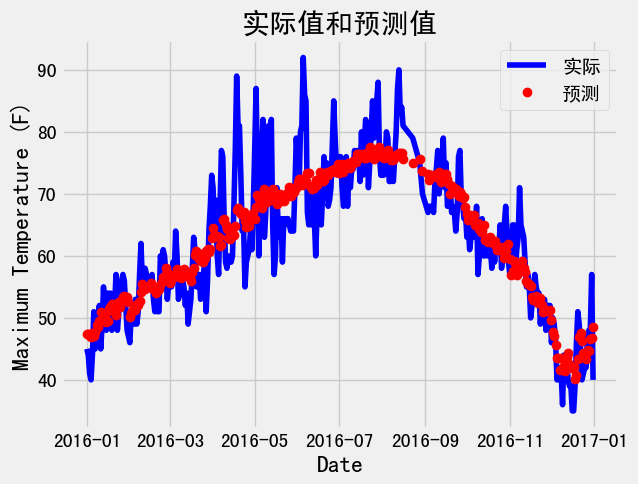

In [76]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()


# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 


# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = '实际')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = '预测')
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('实际值和预测值');